In [40]:
from astropy.io import fits
import numpy as np
from datetime import datetime,timedelta
import pandas as pd

In [205]:
#fits.getheader('exHED.fits',2)

In [206]:
#fits.getheader('exGBM.rsp',2)

In [6]:
#The table is the main job for the response fits file.
#Seems to be 6 columns, where the last contains the response matrix for the channel

In [24]:
#having a look at the matrix to see how it is structured
HDUlist = fits.open("exHED.fits")
HDUlist.info()
rspTable = HDUlist[2].data



Filename: exHED.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  EBOUNDS       1 BinTableHDU     30   40R x 3C   [I, E, E]   
  2  SPECRESP MATRIX    1 BinTableHDU     43   40R x 6C   [E, E, I, I, I, 40D]   


In [34]:
rspTable.shape
#one matrix for each channel, each matrix have 6 entries, where the first 5 entries are:     , and last is respone (?)

(40,)

In [38]:
#check the local rsp file and check if it have the same shape
#Theta, phi angles for GRB201227A: 77.318, -50.463 
#Should use this DRM file: 'HED_drm_mats_75.00_-45.00.txt'
#Using first MATLAB to see how one should read the file

In [136]:
HED_DRM = pd.read_csv('HED_drm_mats_75.00_-45.00.txt',sep=' ',header=None)
HED_DRM = HED_DRM.T #transposing to get the correct format
'''Each column corresponds to a given primary energy bin. Each row in  a  file  corresponds  to  a  given  bin  of  deposited  energy.
Primary  and  deposited  bins  are  identical. The  entries  in  the  column  are  therefore  the  spectrum  of  deposited  energies 
produced by primaries with energies in the given bin chosen, measured in cm2. '''

'Each column corresponds to a given primary energy bin. Each row in  a  file  corresponds  to  a  given  bin  of  deposited  energy.\nPrimary  and  deposited  bins  are  identical. The  entries  in  the  column  are  therefore  the  spectrum  of  deposited  energies \nproduced by primaries with energies in the given bin chosen, measured in cm2. '

In [192]:
HED_bins = np.array([1.000000e+01, 1.258925e+01, 1.584893e+01, 1.995262e+01,
       2.511886e+01, 3.162278e+01, 3.981072e+01, 5.011872e+01,
       6.309573e+01, 7.943282e+01, 1.000000e+02, 1.258925e+02,
       1.584893e+02, 1.995262e+02, 2.511886e+02, 3.162278e+02,
       3.981072e+02, 5.011872e+02, 6.309573e+02, 7.943282e+02,
       1.000000e+03, 1.258925e+03, 1.584893e+03, 1.995262e+03,
       2.511886e+03, 3.162278e+03, 3.981072e+03, 5.011872e+03,
       6.309573e+03, 7.943282e+03, 1.000000e+04, 1.258925e+04,
       1.584893e+04, 1.995262e+04, 2.511886e+04, 3.162278e+04,
       3.981072e+04, 5.011872e+04, 6.309573e+04, 7.943282e+04,1.000000e+05],
      dtype=np.float32)

In [131]:
HED_primary_energy = np.zeros((40,1))
HED_primary_energy[31] = 1000
HED_deposited_spectrum = HED_DRM @ HED_primary_energy

In [118]:
import matplotlib.pyplot as plt

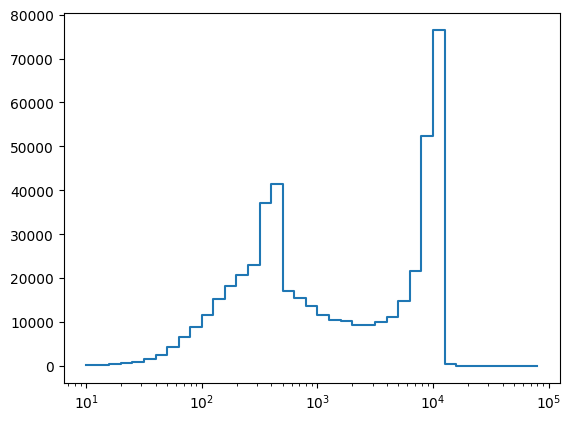

In [134]:
plt.step(HED_bins[:-1],HED_deposited_spectrum)
plt.xscale('log')
#Reproduced same plot as in ASIM paper (DRM is not transposed to reproduced)

In [141]:
np.float32(rspTable[6][5])==HED_ERM.iloc[6].to_numpy(dtype=np.float32)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [145]:
HED_ERM.iloc[30].to_numpy(dtype=np.float32) #where i denotes the channel used

array([ 0.12789588,  0.17808309,  0.24771944,  0.34143072,  0.47671932,
        0.71798176,  1.2124249 ,  2.2104917 ,  3.8683167 ,  5.850536  ,
        7.973527  , 10.4346075 , 13.551825  , 16.818989  , 18.748724  ,
       21.020905  , 34.613316  , 38.257706  , 14.997535  , 12.745531  ,
       11.016634  ,  9.418727  ,  9.181949  ,  8.618106  ,  8.103785  ,
        8.558346  , 10.14876   , 13.09377   , 20.449888  , 49.091724  ,
       83.02383   ,  0.7008155 ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
      dtype=float32)

In [152]:
rspTable.data

In [163]:
DRM = HED_DRM.to_numpy(dtype=np.float32) #we have our DRM in correct format

In [172]:
#Strange that the rows in N_GRP,F_CHAN,N_CHAN are all the same (?)
#now we assign the columns:('ENERG_LO', '>f4'), ('ENERG_HI', '>f4'),('N_GRP', '>i2'),('F_CHAN', '>i2'),('N_CHAN', '>i2'), ('MATRIX', '>f8

In [173]:
#set in HDR: EXTNAME = SPECRESP MATRIX

In [175]:
fits.getheader('exHED.fits',2)

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.4            
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                  334 /Number of bytes per row                         
NAXIS2  =                   40 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                    6 /Number of columns in table                      
EXTNAME = 'SPECRESP MATRIX'    /Extension name                                  
TELESCOP= 'ASIM'               / Telescope or mission name                      
INSTRUME= 'MXGS'               / Instrument name                                
DATE    = '11-06-2020'         / Creation date                                  
ONTIME  =         1.00000000

In [209]:
from datetime import datetime,timedelta
import numpy as np
from astropy.io import fits
import pandas as pd

#needed inputs into HDR:
#the items in the dict is 'KEY', ['VALUE', 'COMMENT']
RSP_dict = {
'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
'T0TIME':['2020-12-27T15:14:06.854','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
'TSTART': [0.0,'[s] Start time of spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
'TSTOP': [0.064,'End time of spectrum accumulation'], #<float> [s]
'EXPOSURE': [0.064,'[s] Integration time in seconds for the PHA data'], #<float> 
'OBJECT': ['GRB201227A','Name of the observed object'], #<str> 
'RA_OBJ': [170.121,'[deg] RA of source'], #<float> 
'DEC_OBJ':  [-73.613,'[deg] Dec of source'], #<float>
'FILENAME': ['example.rsp','RSP filename'] #<str>  ('example.pha')
}
#More keys can be declated. Set generatePHA(see_template=True) to view avalible keys,values & comments from the template HDR's
#TODO: Check the inputs: Might need only the full path to the file. Must be the right theta phi angles!

def generateRSP(RSP_dict=None, DRM_fname=None, bin_lo=None, bin_hi=None, see_headers=False):
    """
    function for generating PHA file for ASIM data.
    RSP_dict <dict>, dictionary containing keywords and values for headers. Possible to set new keywords,values and comments by declaring them
    as 'KEY': ['VALUE','COMMENT'] in the RSP_dict.
    
    bin_lo: <np.array>, array containing the E_MIN boundaries for the channels
    bin_hi: <np.array>, array containing the E_MAX boundaries for the channels
    DRM_fname: <str>, Full path to the HED_DRM. Important to get the right theta/phi angles.
    stat_err: <np.array>, array containing the poission error <float> for each count
    
    RSP_dict: <dict>, key: <str>, value: <str,float,int>. Dictionary for setting value in the headers (Primary, Spectrum & Ebounds).
    Comments must be changed in the 'type'DictHDR.
    
    see_headers: <bool>, wheter to print the template HDR's. If true nothing will be returned
    """
    
    'none'
    
    #Creating template for PRIMARY,SPECTRUM & EBOUNDS HDR
    #change the relevant keywords
    #----------------------------------------------------------------
    primaryDictHDR = {'SIMPLE': [True, 'conforms to FITS standard'],
    'BITPIX': [8, 'array data type'],
    'NAXIS': [0, 'number of array dimensions'],
    'EXTEND': [True, ''],
    'CREATOR': ['ASIM Fits v1.0.0', 'Program name. Written by Andreas Ramsli'],
    'FILETYPE': ['SPECTRUM', 'Name for this type of FITS file'],
    'TELESCOP': ['ASIM', 'Name of mission/satellite'],
    'INSTRUME': ['MXGS: HED', 'Specific instrument used for observation'],
    'ORIGIN': ['University of Bergen', 'Name of institution making file'],
    'DATE': ['none','file creation date [YYYY-MM-DDThh:mm:ss UT]'],
    'TSTART': ['none', '[s] TSTART given relative to T0'],
    'TSTOP': ['none', '[s] TSTOP given relative to T0'],
    'EXPOSURE': ['none', '[s] Integration time in seconds for the PHA data'],
    'FILENAME': ['none', 'Name of this file'],
    'OBJECT': ['none', 'Burst name in standard format, GRB yymmdd'],
    'RADECSYS': ['FK5', 'Stellar reference frame'],
    'EQUINOX': [2000.0, 'Equinox for RA and Dec'],
    'RA_OBJ': ['none', '[deg] Calculated RA of source'],
    'DEC_OBJ': ['none', '[deg] Calculated Dec of source'],
    'T0TIME': ['none', 'Trigger time given as YYYY-MM-DDThh:mm:ss.fff'],
    'USER':['none','Username of creator of this fits file'],
    'BACKFILE': ['none', 'Background FITS file'],
    'RESPFILE': ['none', 'redistribution matrix filename'],}

    rspDictHDR = {'XTENSION': ['BINTABLE', 'binary table extension'],
    'BITPIX': [8, 'array data type'],
    'NAXIS': [2, 'number of array dimensions'],
    'NAXIS1': [334, 'length of dimension 1'],
    'NAXIS2': [40, 'length of dimension 2'],
    'PCOUNT': [0, 'number of group parameters'],
    'GCOUNT': [1, 'number of groups'],
    'TFIELDS': [6, 'number of table fields'],
    'ANCRFILE': ['none', 'ancillary response'],
    'AREASCAL': [1.0, 'Area scaling factor, no field AREASCAL'],
    'BACKFILE': ['none', 'Background FITS file'],
    'BACKSCAL': [1.0, 'Background scale factor, no field BACKSCAL'],
    'CHANTYPE': ['PI', 'channel type [PHA, PI etc]'], #check this!
    'CORRFILE': ['none', 'Correlation FITS file'],
    'CORRSCAL': [0.0, 'Correlation scale factor'],
    'CREATOR': ['ASIM fits v1.0.0','Program name and version. By Andreas Ramsli'],
    'DATAMODE': ['PH', 'Datamode'],
    'DATE': ['none', 'File creation date [UT]'],
    'DATE_END': ['none', 'Date observations ended (yyyy-mm-dd)'],
    'DATE_OBS': ['none', 'Date observations were made [yyyy-mm-dd]'],
    'DETCHANS': [40, 'Total number of detector channels available'],
    'EQUINOX': [2000.0, 'Equinox of celestial coord system'],
    'EXPOSURE': ['none', '[s] Integration time in seconds for the PHA data'],
    'EXTNAME': ['SPECRESP MATRIX', 'Extension name'],
    'FILTER': ['none', 'Instrument filter in use'],
    'HDUCLAS1': ['RESPONSE', 'response dataset'],
    'HDUCLAS2': ['RSP_MATRIX', 'indicating the data stored [TOTAL: gross PHA sp'],
    'HDUCLAS4': ['TYPE:I', 'indicating whether this is a type I or II exten'],
    'HDUCLASS': ['OGIP', 'format conforms to OGIP standard'],
    'HDUVERS': ['1.3.0', 'Version of format [OGIP memo OGIP-92-007]'],
    'HUDCLAS3': ['COUNT', 'indicating further the data stored'],
    'INSTRUME': ['MXGS: HED', 'Instrument name'],
    'OBJECT': ['none', 'Name of observed object'],
    'ORIGIN': ['Univeristy of Bergen','Name of institution making the fits file'],
    'POISSERR': [False, 'Set to false since stat_err is used'],
    'QUALITY': [0, 'no data quality information specified'],
    'GROUPING': [0, 'No special grouping applied'],
    'RADECSYS': ['FK5', 'coord frame used for EQUINOX'],
    'SYS_ERR': [0, 'no systematic error specified'],
    'TELESCOP': ['ASIM', 'Telescope or mission name'],
    'TIME_END': ['none', 'Time observations were made (hh:mm:ss)'],
    'TIME_OBS': ['none', 'Time observations were made (hh:mm:ss)'],
    'TLMAX1': [40, 'Highest legal channel number'],
    'TLMIN1': [1, 'Lowest legal channel number'],
    'T0TIME': ['none', 'Trigger time UT (YYYY-MM-DDThh:mm:ss.fff)'],
    'TSTART': ['none', '[s] Start time of spectrum accumulation relativ'],
    'TSTOP': ['none', '[s] End time of spectrum accumulation relative'],
    'COMMENT': ['TSTART/STOP is given relative to the trigger time (T0TIME)', ''],
    'USER': ['none', 'Username of creator of this fits file'],
    'XFLT0001': ['none', 'XSPEC selection filter description'],
    'TTYPE1': ['ENERG_LO', 'Left bin edge'],
    'TFORM1': ['1E', ''],
    'TTYPE2': ['ENERG_HI', 'Right bin edge'], 
    'TFORM2': ['1E', ''],
    'TTYPE3': ['N_GRP', ''], 
    'TFORM3': ['1I', ''],
    'TTYPE4': ['F_CHAN',''],
    'TFORM4': ['1I',''],
    'TTYPE5': ['N_CHAN',''],
    'TFORM5': ['1I',''],
    'TTYPE6': ['MATRIX', 'Detector response matrix'],
    'TFORM6': ['40D',''],
    'TUNIT1': ['keV', 'Unit for this column'],
    'TUNIT2': ['keV', 'Unit for this column'],
    'TUNIT6': ['cm**2', 'Unit for this column'],
    'RA_OBJ': ['none', '[deg] Calculated RA of source'],
    'DEC_OBJ': ['none', '[deg] Calculated Dec of source']}

    eboundsDictHDR = {'XTENSION': ['BINTABLE', 'binary table extension'],
    'BITPIX': [8, 'Required value'],
    'NAXIS': [2, 'Required value'],
    'NAXIS1': [10, 'Number of bytes per row'],
    'NAXIS2': [40, 'Number of rows'],
    'PCOUNT': [0, 'Normally 0 [no varying arrays]'],
    'GCOUNT': [1, 'Required value'],
    'TFIELDS': [3, 'Number of columns in table'],
    'EXTNAME': ['EBOUNDS', 'Extension name'],
    'TELESCOP': ['ASIM', 'Telescope or mission name'],
    'INSTRUME': ['MXGS: HED', 'Instrument name'],
    'DATE': ['none', 'Creation date'],
    'DETCHANS': [40, 'Total number of detector channels available'],
    'CHANTYPE': ['PHA', 'Channel type'],
    'TUNIT2': ['keV', 'Unit for this column'],
    'TUNIT3': ['keV', 'Unit for this column'],
    'TLMIN1': [1, 'Lowest legal channel number'],
    'TLMAX': [40, 'Highest legal channel number'],
    'EXTVER': [1, 'Version number of this extensio'],
    'HDUCLASS': ['OGIP', 'Required for RMF'],
    'HDUVERS': ['1.3.0', 'version of the file format'],
    'HDUCLAS1': ['RESPONSE', 'Typically found in RMF files'],
    'HDUCLAS2': ['EBOUNDS', 'Boundaries of energybins'],
    'TFORM1': ['I', ''],
    'TFORM2': ['E', ''],
    'TFORM3': ['E', ''],
    'TTYPE1': ['CHANNEL', ''],
    'TTYPE2': ['E_MIN', '[keV] minimum energy of channel n'],
    'TTYPE3': ['E_MAX', '[keV] max energy of channel n']} 
    
    
    #Setting KEYWORDS in dict based on input
    #--------------------------------------------------------------------------------
    for key in RSP_dict.keys():
        try:
            primaryDictHDR[key][0] = RSP_dict[key]
            rspDictHDR[key][0] = RSP_dict[key]
            eboundsDictHDR[key][0] = RSP_dict[key]
        except KeyError: #creating new keys if they are not in the template dict
            if len(RSP_dict[key])<=1 or len(RSP_dict[key])>2:
                return(print("Value and comment must be set for the keyword '{}' as a list".format(key)))
            else:
                primaryDictHDR[key] = [RSP_dict[key][0],RSP_dict[key][1]]
                rspDictHDR[key] = [RSP_dict[key][0],RSP_dict[key][1]]
                eboundsDictHDR[key] =[RSP_dict[key][0],RSP_dict[key][1]]
                
    file_creation_date = datetime.isoformat(datetime.utcnow()) #setting file creation date to UTC now
    primaryDictHDR['DATE'][0], rspDictHDR['DATE'][0], eboundsDictHDR['DATE'][0] = file_creation_date,file_creation_date,file_creation_date
    
    #calculating the DATE_OBS,DATE_END,TIME_OBS,TIME_END from input
    try:
        T0TIME = datetime.fromisoformat(RSP_dict['T0TIME'][0])
        OBS_START = T0TIME + timedelta(seconds=RSP_dict['TSTART'][0])
        OBS_END = T0TIME + timedelta(seconds=RSP_dict['TSTOP'][0])
        
        rspDictHDR['DATE_OBS'][0] = OBS_START.strftime('%Y-%m-%d')
        rspDictHDR['TIME_OBS'][0] = OBS_START.strftime('%H:%M:%S')
        rspDictHDR['DATE_END'][0] = OBS_END.strftime('%Y-%m-%d')
        rspDictHDR['TIME_END'][0] = OBS_END.strftime('%H:%M:%S')
        
    except KeyError:
        return(print('Something wrong with KEY. Check that T0TIME is set in input_dict'))
    
    
    
    #Setting headers
    #----------------------------------------------------------------------------------
    primaryHDR,DRM_hdr, eboundsHDR = fits.Header(),fits.Header(),fits.Header()
    
    
    for row in primaryDictHDR.items():
        primaryHDR[row[0]] = row[1][0],row[1][1]
    for row in rspDictHDR.items():
        DRM_hdr[row[0]] = row[1][0],row[1][1]
    for row in eboundsDictHDR.items():
        eboundsHDR[row[0]] = row[1][0],row[1][1]
        
    if see_headers==True:
        print("PrimaryHDR: \n", primaryHDR.cards)
        print("DRM_hdr: \n",DRM_hdr.cards)
        print("EboundsHDR: \n",eboundsHDR.cards)
    else:
        primaryHDU = fits.PrimaryHDU(header=primaryHDR) #PrimaryHDU
        
        HED_DRM = pd.read_csv(DRM_fname, sep=' ',header=None).T.to_numpy(dtype=np.float32) #Getting DRM from DRM_fname
       
        DRM_shape = np.shape(HED_DRM)
        
        if not np.all([DRM_shape[0],len(bin_lo),len(bin_hi)]) == True:
            return(print('Length of input arrays are not the same. Check shape of DRM = (40,40)'))
        
        #Creating table for SPECTRUM HDU file
        #------------------------------------
        eboundMinColumn = fits.Column(name=DRM_hdr.cards['TTYPE1'][1],format=DRM_hdr.cards['TFORM1'][1], array=bin_lo)
        eboundMaxColumn = fits.Column(name=DRM_hdr.cards['TTYPE2'][1],format=DRM_hdr.cards['TFORM2'][1], array=bin_hi)
        #Do we actually need the N_GRP, F_CHAN, N_CHAN columns?
        ngrpColumn = fits.Column(name=DRM_hdr.cards['TTYPE3'][1],format=DRM_hdr.cards['TFORM3'][1], array=np.array([1]*DRM_shape[0]))
        fchanColumn = fits.Column(name=DRM_hdr.cards['TTYPE4'][1],format=DRM_hdr.cards['TFORM4'][1], array=np.array([1]*DRM_shape[0]))
        nchanColumn = fits.Column(name=DRM_hdr.cards['TTYPE5'][1],format=DRM_hdr.cards['TFORM5'][1], 
                                  array=np.array([DRM_shape[0]]*DRM_shape[0])) #this is the length of the rows. might be written better
        
        drmColumn = fits.Column(name=DRM_hdr.cards['TTYPE6'][1],format=DRM_hdr.cards['TFORM6'][1], array=HED_DRM)
        
        drmTableHDU = fits.BinTableHDU.from_columns(columns=[eboundMinColumn,eboundMaxColumn,ngrpColumn,fchanColumn,nchanColumn,drmColumn],header=DRM_hdr) 
          
        
        #Creating table for EBOUNDS HDU file
        #-----------------------------------
        channelColumn = fits.Column(name=eboundsHDR.cards['TTYPE1'][1],format=eboundsHDR.cards['TFORM1'][1], array=np.arange(1,len(bin_lo)+1))
        eboundsTableHDU = fits.BinTableHDU.from_columns(columns=[channelColumn,eboundMinColumn,eboundMaxColumn],header=eboundsHDR) 
        
        
        
        
        HDUL = fits.HDUList([primaryHDU,drmTableHDU,eboundsTableHDU])
        try:
            HDUL.writeto(primaryHDR.cards['FILENAME'][1],checksum=True)
        except KeyError:
            print("FILENAME keyword must be set in input dict")

In [208]:
generateRSP(RSP_dict=RSP_dict,DRM_fname='HED_drm_mats_75.00_-45.00.txt',bin_lo=HED_bins[:-1],bin_hi=HED_bins[1:],see_headers=False)

In [ ]:
#fverify, GRB1902... burst again